# Confocal Scan

In [2]:
import logging
from argparse import Namespace
import matplotlib.pyplot as plt

In [3]:
import nipiezojenapy
import qt3utils.nidaq
import qt3utils.datagenerators as datasources
import qt3utils.datagenerators.piezoscanner
import qt3utils.nidaq.config

In [5]:
logging.basicConfig(level = logging.INFO) #set to logging.WARNING to suppress logged information to cells

In [6]:
args = Namespace(daq_name='Dev1', 
                 signal_terminal='PFI0', 
                 clock_rate=100000, 
                 num_data_samples_per_batch=50, 
                 clock_terminal=None, 
                 rwtimeout=10, 
                 signal_counter='ctr2', 
                 piezo_write_channels='ao0,ao1,ao2', 
                 piezo_read_channels='ai0,ai1,ai2', 
                 randomtest=False, 
                 cmap='Greys_r')

In [7]:
controller = nipiezojenapy.PiezoControl(device_name = args.daq_name,
                                  write_channels = args.piezo_write_channels.split(','),
                                  read_channels = args.piezo_read_channels.split(','))

In [8]:
data_acq = datasources.NiDaqDigitalInputRateCounter(args.daq_name,
                             args.signal_terminal,
                             args.clock_rate,
                             args.num_data_samples_per_batch,
                             args.clock_terminal,
                             args.rwtimeout,
                             args.signal_counter)

In [9]:
scanner = datasources.NiDaqPiezoScanner(data_acq, controller)

In [10]:
scanner.set_scan_range(40, 60, 40, 60)

In [14]:
scanner.__dict__

{'running': False,
 'current_y': 0,
 'ymin': 40,
 'ymax': 60,
 'xmin': 40,
 'xmax': 60,
 'step_size': 0.5,
 'raster_line_pause': 0.15,
 'data': [],
 'controller': <nipiezojenapy.controller.PiezoControl at 0x2016b737400>,
 'num_daq_batches': 1,
 'ratecounter': <qt3utils.datagenerators.daqsamplers.NiDaqDigitalInputRateCounter at 0x2016b6b3190>}

In [15]:
controller.get_current_position()

[0.04567673118400789, 0.004451061808055372, -0.05223423357139445]

In [18]:
some_optimal_z = 15 #use the qt3scope tool and the nipiezojenapy tool to find an optimal z
#OR, maybe can run a large optimize scan across all of z. see the optimize code below.
controller.go_to_position(z = some_optimal_z)

INFO:nipiezojenapy.controller:go to position z: 15.00


In [16]:
scanner.set_to_starting_position()

INFO:nipiezojenapy.controller:go to position x: 40.00 y: 40.00


In [20]:
controller.get_current_position()

[39.97804581427617, 40.04503830190768, 15.03121610872722]

In [21]:
scanner.start()

In [ ]:
while scanner.still_scanning():
            scanner.scan_x()
            scanner.move_y()
            
#the output of this cell has been removed. Normally, with loglevel = INFO, each step of the scan prints a few lines of information

In [51]:
scanner.stop()

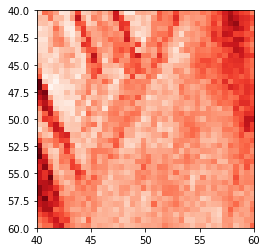

In [28]:
plt.imshow(scanner.data, cmap='Reds', extent = [40, 60, 60, 40])

In [30]:
#perform some computational magic to locate a position of interest.
#for example, perform a convolution of the image with a mask that
#represents your interest (for example, a single NV center that is 
#significantly isolated from other NV centers in the sample
#https://en.wikipedia.org/wiki/Kernel_(image_processing)

#x_opt, y_opt = find_best_nv_center(scanner.data)
x_opt = 46
y_opt = 43
controller.go_to_position(x_opt, y_opt)

INFO:nipiezojenapy.controller:go to position x: 46.00 y: 43.00


In [ ]:
data, scanvals, x_opt, fit_coef = scanner.optimize_position('x', x_opt, width = 2, step_size = 0.25)
controller.go_to_position(x = x_opt)

data, scanvals, y_opt, fit_coef = scanner.optimize_position('y', y_opt)
controller.go_to_position(y = y_opt)

data, scanvals, z_opt, fit_coef = scanner.optimize_position('z', controller.get_current_position()[2], width = 10)
controller.go_to_position(z = z_opt)

data, scanvals, x_opt, fit_coef = scanner.optimize_position('x', x_opt)
controller.go_to_position(x = x_opt)

data, scanvals, y_opt, fit_coef = scanner.optimize_position('y', y_opt)
controller.go_to_position(y = y_opt)

#the log output of this cell has been omitted

In [33]:
controller.get_current_position()

[44.38667251599523, 43.42043245163783, 15.049252369319495]

#### Now at an optimized position, one could then perform other experiments

In [ ]:
# pulser = qcsapphire.Pulser('COM4')
# rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')
# nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

# experiment = qt3utils.experiments.podmr.PulsedODMR(pulser, rfsynth, nidaq_config, 
#                                                    photon_counter_nidaq_terminal = 'PFI0',
#                                                    clock_nidaq_terminal = 'PFI12',
#                                                    rf_pulse_duration = 1e-6, 
#                                                    rf_power = -25, 
#                                                    aom_width = 5e-6)
# pulsed_odmr_scan_data = experiment.run(N_cycles=10000)

# Save Data

In [47]:
scan_data = {'ymin':scanner.ymin, 'ymax':scanner.ymax, 
             'xmin':scanner.xmin, 'xmax':scanner.xmax,
            'confocal_scan_data':scanner.data}

#scan_data['podmr'] = pulsed_odmr_scan_data

In [48]:
import pickle 
myfilename = 'ppm_sample_oct4_2022_1mW.pickle'
with open(myfilename, 'wb') as handle:
    pickle.dump(scan_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load and Plot Data

In [49]:
with open(myfilename, 'rb') as handle:
    loaded_scan_data = pickle.load(handle)

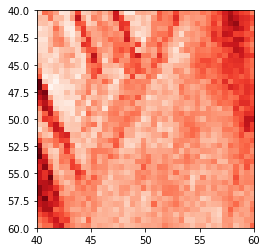

In [50]:
xmin = loaded_scan_data['xmin']
xmax = loaded_scan_data['xmax']
ymin = loaded_scan_data['ymin']
ymax = loaded_scan_data['ymax']

plt.imshow(loaded_scan_data['confocal_scan_data'], cmap='Reds', extent = [xmin, xmax, ymax, ymin])